## N1 Health - Food Access
### 1. The Challenge
Many urban communities across the US are facing significant health issues which are exacerbated by limited access to nutritious food - a key social determinant of health. 

The goal of this analysis is to improve community health while making the Medicare Advantage plan more attractive to potential prospects.

---
### 2. The Approach
Given two rich datasets to work with:

- ***CDC's 500 Cities Project:*** Prevalent health risk factors accross the US by Census Tracts

- ***USDA's Food Environment Atlas:*** State and county level food environment factors

2.1: Bring the datasets together by their FIPS code, making the general assumption that all tracts inside of a county share the same food access statistics.
 
2.2: Develop a 'Need Score' to rank census tracts based on both health burdens and food access challenges.

In [12]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

---
### 3. Reading the data

In [20]:
def read_tables(db_path, table_names):
    dataframes = {}
    conn = None

    # Read in specified tables in database file
    try:
        conn = sqlite3.connect(db_path)

        for table_name in table_names:
            print(f"Reading table: {table_name}")
            query = query = f"SELECT * FROM {table_name}"
            dataframes[table_name] = pd.read_sql_query(query, conn)
            print(f"Successfull read of {table_name} into dataframe with shape: {dataframes[table_name].shape}")

    except sqlite3.Error as e:
        print(f"SQLite error: {e}")
    except Exception as e:
        print(f"Error: {e}")
    finally:
        if conn:
            conn.close()
            print("All done.")

    return dataframes

# Populate dataframes using read_tables
try:
    table_names = ['access', 'five_hundred_cities']
    dataframes = read_tables('challenge.db', table_names)

    raw_cities_df = dataframes['five_hundred_cities']
    raw_access_df = dataframes['access']
except Exception as e:
    print(f"Error loading initial data: {e}. Double check data source.")

Reading table: access
Successfull read of access into dataframe with shape: (3143, 45)
Reading table: five_hundred_cities
Successfull read of five_hundred_cities into dataframe with shape: (27210, 64)
All done.


---
### 4. Data Preparation & County-Level Merge

In [3]:
# Clean 'five_hundred_cities' and add CountyFIPS
cities_df = raw_cities_df.copy()
cities_drop_cols = ['Unnamed: 0', 'index']
existing_cities_drop_cols = [col for col in cities_drop_cols if col in cities_df.columns]
if existing_cities_drop_cols:
    cities_df = cities_df.drop(columns=existing_cities_drop_cols)

for col in cities_df.columns:
    if col.endswith('_Crude95CI'):
        base_name = col.replace('_Crude95CI', '')
        def extract_ci(ci_str):
            if pd.isna(ci_str) or not isinstance(ci_str, str): 
                return pd.NA, pd.NA
            try:
                parts = ci_str.strip('()').split(',')
                if len(parts) == 2: 
                    return float(parts[0].strip()), float(parts[1].strip())
            except ValueError: 
                pass
            return pd.NA, pd.NA
        ci_vals = cities_df[col].apply(extract_ci)
        cities_df[f'{base_name}_Lower95CI'] = pd.to_numeric([val[0] for val in ci_vals], errors='coerce')
        cities_df[f'{base_name}_Upper95CI'] = pd.to_numeric([val[1] for val in ci_vals], errors='coerce')

if 'TractFIPS' in cities_df.columns:
    cities_df['TractFIPS'] = cities_df['TractFIPS'].astype(np.int64)
    cities_df['CountyFIPS'] = cities_df['TractFIPS'].astype(str).str.zfill(11).str[:5].astype(np.int64)
else:
    raise KeyError("TractFIPS column missing in five-hundred-cities dataset, cannot proceed.")

In [4]:
# Prepare 'access' data for County-Level Merge
access_county_df = raw_access_df.copy()
food_access_cols = []
if 'LACCESS_POP15' in access_county_df.columns: 
    food_access_cols.append('LACCESS_POP15')
if 'PCT_LACCESS_POP15' in access_county_df.columns: 
    food_access_cols.append('PCT_LACCESS_POP15')
if 'LACCESS_LOWI15' in access_county_df.columns: 
    food_access_cols.append('LACCESS_LOWI15')
if 'PCT_LACCESS_LOWI15' in access_county_df.columns: 
    food_access_cols.append('PCT_LACCESS_LOWI15')

if 'FIPS' in access_county_df.columns and food_access_cols:
    access_county_df = access_county_df.rename(columns={'FIPS': 'CountyFIPS'})
    access_county_df['CountyFIPS'] = access_county_df['CountyFIPS'].astype(np.int64)
    access_keep_cols = ['CountyFIPS'] + food_access_cols
    access_county_df = access_county_df[access_keep_cols]
    for col in food_access_cols:
        access_county_df[col] = pd.to_numeric(access_county_df[col], errors='coerce')
    access_county_df = access_county_df.drop_duplicates(subset=['CountyFIPS'], keep='first')
else:
    print("Warning: 'FIPS' column not in access_df or no food access variables selected. County food data will be empty.")
    access_county_df = pd.DataFrame(columns=['CountyFIPS'] + food_access_cols)

# Merge Datasets at county-level
merged_df = pd.merge(cities_df, access_county_df, on='CountyFIPS', how='left')
merged_df.to_csv("merged_health_food_access_county_level.csv", index=False)

---
### 5. Analysis - Key Findings
In this section we will answer the principal questions of the analysis.

#### Q1: Where to deploy? Ranking Census Tracts
*Recommendation for deployment locations, justified by relevant factors*

The analysis produced by the synthesized *Need Score* pinpoints specific census tracts with the most urgent needs

Some top locations and their *Need Score*:
* Albany GA: **0.846** (many census tracts)
* Chattanooga TN: **0.822**
* Augusta GA: **0.805**
* McAllen TX: **0.799**

In [19]:
# Q1:
health_rank_cols = ['DIABETES_CrudePrev', 'OBESITY_CrudePrev', 'BPHIGH_CrudePrev']
food_access_rank_cols = ['PCT_LACCESS_LOWI15', 'PCT_LACCESS_POP15']
rank_context_cols = ['TractFIPS', 'PlaceName', 'StateAbbr', 'CountyFIPS', 'Population2010'] + \
                    health_rank_cols + food_access_rank_cols
ranking_df = merged_df[rank_context_cols].copy()
scaler = MinMaxScaler()

valid_health_rank_cols = [col for col in health_rank_cols if col in ranking_df.columns]
valid_food_access_rank_cols = [col for col in food_access_rank_cols if col in ranking_df.columns]

if valid_health_rank_cols:
    ranking_df[[f'{col}_norm' for col in valid_health_rank_cols]] = scaler.fit_transform(ranking_df[valid_health_rank_cols])
if valid_food_access_rank_cols:
    ranking_df[[f'{col}_norm' for col in valid_food_access_rank_cols]] = scaler.fit_transform(ranking_df[valid_food_access_rank_cols])

if valid_health_rank_cols:
    ranking_df['HealthNeedScore'] = ranking_df[[f'{col}_norm' for col in valid_health_rank_cols]].mean(axis=1)
else: 
    ranking_df['HealthNeedScore'] = 0
if valid_food_access_rank_cols:
    ranking_df['FoodAccessScore'] = ranking_df[[f'{col}_norm' for col in valid_food_access_rank_cols]].mean(axis=1)
else: 
    ranking_df['FoodAccessScore'] = 0

if valid_health_rank_cols and valid_food_access_rank_cols:
    ranking_df['OverallNeedScore'] = (ranking_df['HealthNeedScore'] + ranking_df['FoodAccessScore']) / 2
elif valid_health_rank_cols: 
    ranking_df['OverallNeedScore'] = ranking_df['HealthNeedScore']
elif valid_food_access_rank_cols: 
    ranking_df['OverallNeedScore'] = ranking_df['FoodAccessScore']
else: 
    ranking_df['OverallNeedScore'] = np.nan

ranked_tracts_df = ranking_df.sort_values(by='OverallNeedScore', ascending=False)
q1_output_cols = rank_context_cols + ['HealthNeedScore', 'FoodAccessScore', 'OverallNeedScore']
q1_output_cols = [col for col in q1_output_cols if col in ranked_tracts_df.columns]
print("Top 10 Ranked Census Tracts:")
print(ranked_tracts_df[q1_output_cols].head(10))
ranked_tracts_df.to_csv("ranked_tracts_for_deployment.csv", index=False)

Top 10 Ranked Census Tracts:
         TractFIPS    PlaceName StateAbbr  CountyFIPS  Population2010  DIABETES_CrudePrev  OBESITY_CrudePrev  BPHIGH_CrudePrev  PCT_LACCESS_LOWI15  PCT_LACCESS_POP15  HealthNeedScore  \
9176   13095010601       Albany        GA       13095            2423                24.0               49.6              53.4           22.627832          39.073196         0.718603   
9182   13095011400       Albany        GA       13095            1557                23.1               49.0              52.9           22.627832          39.073196         0.704206   
9159   13095000200       Albany        GA       13095            3123                21.3               50.0              49.5           22.627832          39.073196         0.678069   
22062  47065001600  Chattanooga        TN       47065            2481                31.4               51.6              61.9           13.816605          41.156664         0.839537   
9170   13095001500       Albany        GA

---
#### Q2: How many people will be included?

*Estimates for total population included*

Focusing on just the top 500 tracts (top ~2% out of 27211):
* Estimated total population of **1.6 million** 

In [16]:
# Q2:
q2_top_n = 500
q2_df = ranked_tracts_df.head(q2_top_n).copy()
q2_total_pop = q2_df['Population2010'].sum()
print(f"\nTotal Population2010 in top {q2_top_n} tracts: {q2_total_pop:,.0f}")


Total Population2010 in top 500 tracts: 1,605,363


---
#### Q3: Which subgroup?
*Identification of key subgroup that would benefit the most from the program*

The communities in these high-priority tracts face disproportionately high rates of chronic diseases and severe food access limitations
* The top 500 tracts present **~81% higher Diabetes rates** than the overall population
* Low Income individuals in the top 500 tracts present a **~200% increase in difficulty with food access**

In [18]:
# Q3:
q3_all_cols = valid_health_rank_cols + valid_food_access_rank_cols
q3_n_tracts = min(500, len(ranked_tracts_df.dropna(subset=['OverallNeedScore']))) 
if q3_n_tracts > 0 and q3_all_cols:
    q3_top_df = ranked_tracts_df.head(q3_n_tracts)
    q3_top_avgs = q3_top_df[q3_all_cols].mean()
    q3_overall_avgs = ranked_tracts_df[q3_all_cols].mean()
    q3_comp_df = pd.DataFrame({
        f'Average_Top_{q3_n_tracts}_Tracts': q3_top_avgs,
        'Average_Overall_Dataset': q3_overall_avgs
    })
    q3_comp_df['Difference'] = q3_comp_df[f'Average_Top_{q3_n_tracts}_Tracts'] - q3_comp_df['Average_Overall_Dataset']
    q3_comp_df['Percentage_Higher_In_Top_N (%)'] = \
        (q3_comp_df['Difference'] / q3_comp_df['Average_Overall_Dataset']) * 100
    print("Comparison of Key Indicators: Top Tracts vs. Overall Dataset")
    print(q3_comp_df)

Comparison of Key Indicators: Top Tracts vs. Overall Dataset
                    Average_Top_500_Tracts  Average_Overall_Dataset  Difference  Percentage_Higher_In_Top_N (%)
DIABETES_CrudePrev               19.545400                10.811062    8.734338                       80.790747
OBESITY_CrudePrev                45.431600                30.472922   14.958678                       49.088428
BPHIGH_CrudePrev                 46.291200                30.653208   15.637992                       51.015840
PCT_LACCESS_LOWI15               15.126089                 4.981841   10.144248                      203.624467
PCT_LACCESS_POP15                33.540431                16.125837   17.414593                      107.991871


---
#### Q4: Projected impact?

*Plausible projection of impact*

Again, focusing on just the top 500 tracts (top ~2% out of 27211):
* Estimated total population of **1.6 million** 
* There's an estimated **290,544 diabetics**
* Assuming an illustrative engagement rate of 20%: **58,109 diabetics** will engage with the program 

Note: *Finding real engagement rates entails a research project of its own with preliminary data.*

In [ ]:
# Q4: Projected impact? (using Q3's top N for consistency)
if q3_n_tracts > 0 and 'Population2010' in q3_top_df.columns and 'DIABETES_CrudePrev' in q3_top_df.columns:
    q4_top_pop = q3_top_df['Population2010'].sum()
    q4_top_est_diabetics = ((q3_top_df['DIABETES_CrudePrev'] / 100) * q3_top_df['Population2010']).sum()
    q4_engage_rate = 0.20 # Same as q2_engage_rate, kept separate if rates differ later
    q4_potential_engage = q4_top_est_diabetics * q4_engage_rate
    print(f"Focusing on the top {q3_n_tracts} tracts:")
    print(f"  - Total Population: {q4_top_pop:,.0f}")
    print(f"  - Estimated Individuals with Diabetes: {q4_top_est_diabetics:,.0f}")
    print(f"  - Potential Program Engagement (Diabetes, @{q4_engage_rate*100}% rate): {q4_potential_engage:,.0f} individuals.")
    

Focusing on the top 500 tracts:
  - Total Population: 1,605,363
  - Estimated Individuals with Diabetes: 290,544
  - Potential Program Engagement (Diabetes, @20.0% rate): 58,109 individuals.


---

#### 6. Conclusion: Solutions & Impact
After extensive analysis, it's highly recommended to **deploy targeted food access programs in the identified high-need census tracts.**

#### Addressing these tracts will:
    * Improve health outcomes for engaged individuals.
    * Enhance value in the Membership plan.
    * Create a stronger community presence for the healthcare system.

Data visualizations and .csv files for the analysis and question responses can be found in the project folder. 

---
#### 7. Data Visualizations

##### Visualization 1: Top Priority Tracts

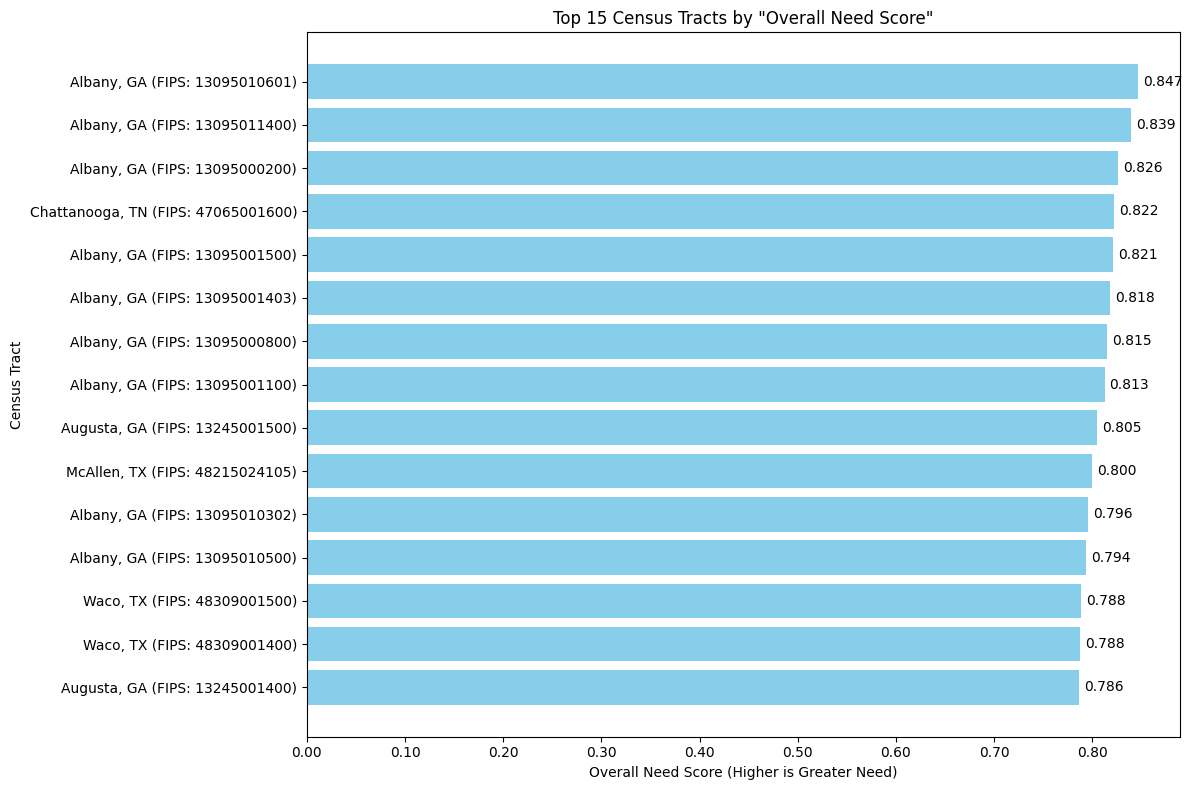

In [32]:
# V1
if not ranked_tracts_df.empty and 'OverallNeedScore' in ranked_tracts_df.columns:
    viz1_n_tracts = 15
    viz1_data = ranked_tracts_df.dropna(subset=['OverallNeedScore']).head(viz1_n_tracts).copy()
    viz1_data['Label'] = viz1_data['PlaceName'] + ", " + viz1_data['StateAbbr'] + " (FIPS: " + viz1_data['TractFIPS'].astype(str) + ")"
    viz1_data = viz1_data.sort_values(by='OverallNeedScore', ascending=True)
    plt.figure(figsize=(12, 8))
    viz1_bars = plt.barh(viz1_data['Label'], viz1_data['OverallNeedScore'], color='skyblue')
    plt.xlabel('Overall Need Score (Higher is Greater Need)')
    plt.ylabel('Census Tract')
    plt.title(f'Top {viz1_n_tracts} Census Tracts by "Overall Need Score"')
    plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    for bar in viz1_bars: plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center', ha='left')
    plt.tight_layout()
    plt.savefig("visualization_1_top_priority_tracts.png")
    plt.show()
    plt.close()

##### Visualization 2: Subgroup Profile

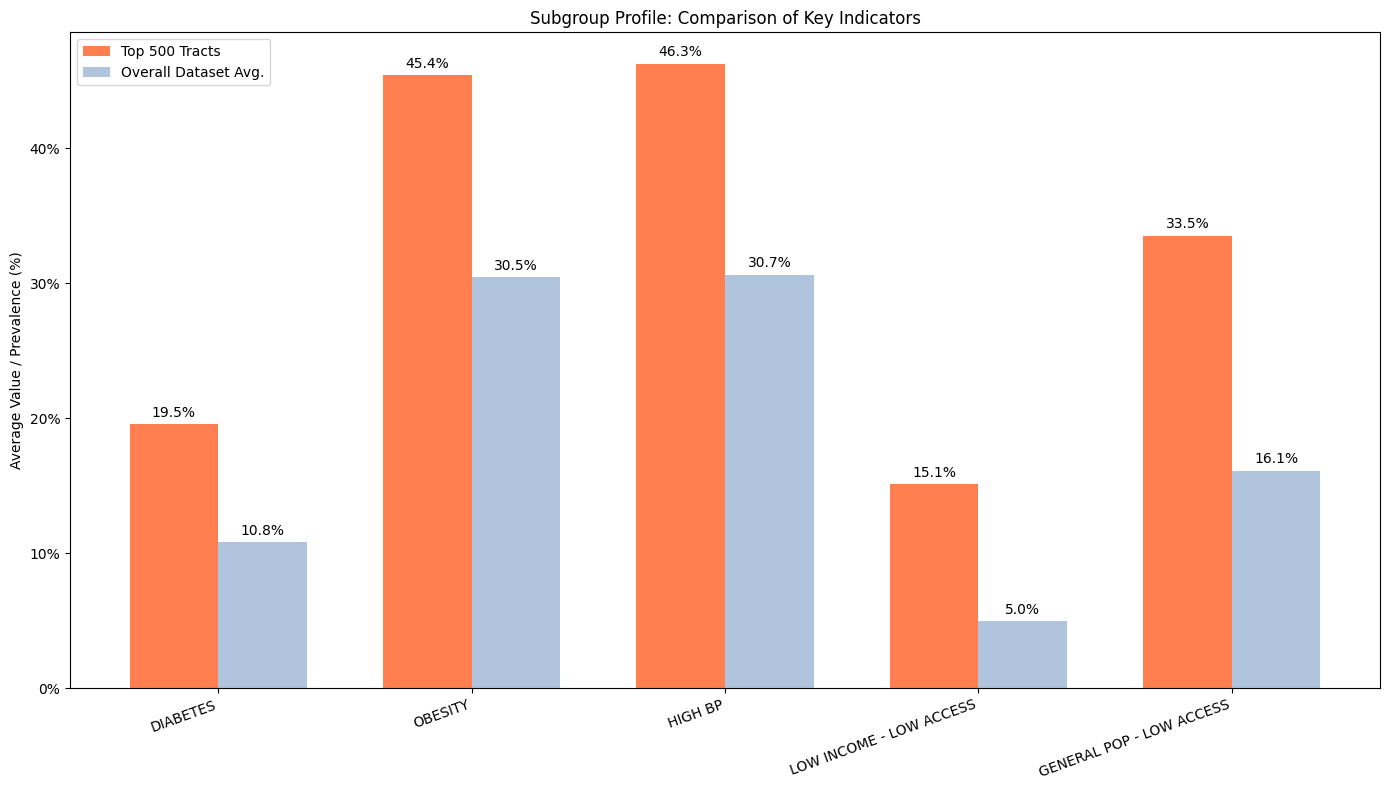

In [28]:
# V2
if q3_n_tracts > 0 and 'q3_comp_df' in locals() and not q3_comp_df.empty:
    #viz2_labels = [col.replace('_CrudePrev', ' Prev.').replace('PCT_', '% ') for col in q3_comp_df.index]
    viz2_labels = ['DIABETES', 'OBESITY', 'HIGH BP', 'LOW INCOME - LOW ACCESS', 'GENERAL POP - LOW ACCESS']
    x_viz2 = np.arange(len(q3_comp_df.index))
    viz2_bar_w = 0.35
    fig_viz2, ax_viz2 = plt.subplots(figsize=(14, 8))
    rects1_viz2 = ax_viz2.bar(x_viz2 - viz2_bar_w/2, q3_comp_df[f'Average_Top_{q3_n_tracts}_Tracts'], viz2_bar_w, label=f'Top {q3_n_tracts} Tracts', color='coral')
    rects2_viz2 = ax_viz2.bar(x_viz2 + viz2_bar_w/2, q3_comp_df['Average_Overall_Dataset'], viz2_bar_w, label='Overall Dataset Avg.', color='lightsteelblue')
    ax_viz2.set_ylabel('Average Value / Prevalence (%)')
    ax_viz2.set_title('Subgroup Profile: Comparison of Key Indicators')
    ax_viz2.set_xticks(x_viz2)
    ax_viz2.set_xticklabels(viz2_labels, rotation=20, ha='right')
    ax_viz2.legend(loc='upper left')
    ax_viz2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100.0, decimals=0))
    def autolabel_viz2(rects, ax_to_use):
        for rect in rects:
            height = rect.get_height()
            ax_to_use.annotate(f'{height:.1f}%', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    autolabel_viz2(rects1_viz2, ax_viz2)
    autolabel_viz2(rects2_viz2, ax_viz2)
    fig_viz2.tight_layout()
    plt.savefig("visualization_2_subgroup_profile.png")
    plt.show()
    plt.close()
else:
    print("Skipping Visualization 2 due to missing Q3 comparison data from this run.")

##### Visualization 3: Projected Impact Summary

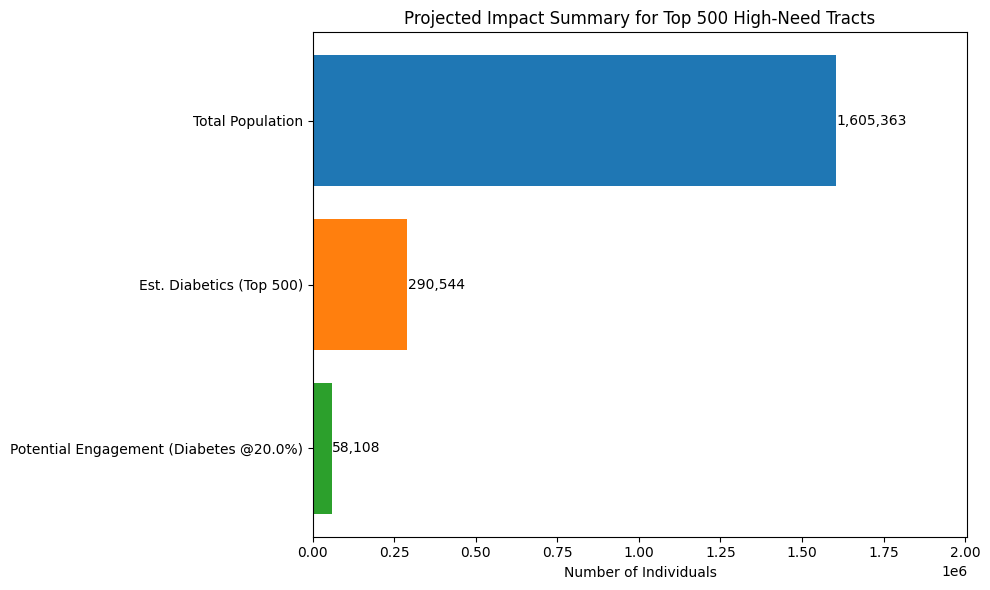

In [23]:
# V3
if q3_n_tracts > 0 and 'q4_top_pop' in locals(): # Check if Q4 variables were calculated
    viz3_data = {
        'Metric': ['Total Population', f'Est. Diabetics (Top {q3_n_tracts})', f'Potential Engagement (Diabetes @{q4_engage_rate*100}%)'],
        'Value': [q4_top_pop, q4_top_est_diabetics, q4_potential_engage]
    }
    viz3_df = pd.DataFrame(viz3_data)
    plt.figure(figsize=(10, 6))
    viz3_bars = plt.barh(viz3_df['Metric'], viz3_df['Value'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.xlabel('Number of Individuals')
    plt.title(f'Projected Impact Summary for Top {q3_n_tracts} High-Need Tracts')
    plt.gca().invert_yaxis()
    for i, bar in enumerate(viz3_bars): plt.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2, f'{int(bar.get_width()):,}', va='center', ha='left')
    plt.xlim(0, viz3_df['Value'].max() * 1.25)
    plt.tight_layout()
    plt.savefig("visualization_3_projected_impact.png")
    plt.show()
    plt.close()
else:
    print("Skipping Visualization 3 due to missing Q4 impact data from this run.")